In [1]:
import os
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [2]:

import pandas as pd 
import re

dataset = pd.read_csv('../data/labeled_data.csv', index_col=False)

def process_tweets(df):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    :return:
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = []

    for i in range(len(df)):
        text = df['tweet'][i]
        # 1) url
        text = re.sub(giant_url_regex, 'URLHERE', text)
        # 2) lots of whitespace
        text = re.sub(space_pattern, ' ', text)
        # 3) mentions
        text = re.sub(mention_regex, 'MENTIONHERE', text)
        parsed_text.append(text)
    df['tweet'] = parsed_text
    return df

dataset = process_tweets(dataset)
dataset.head()


,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT MENTIONHERE: As a woman you shouldn't c...
1,1,3,0,3,0,1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...
2,2,3,0,3,0,1,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...
3,3,3,0,2,1,1,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...


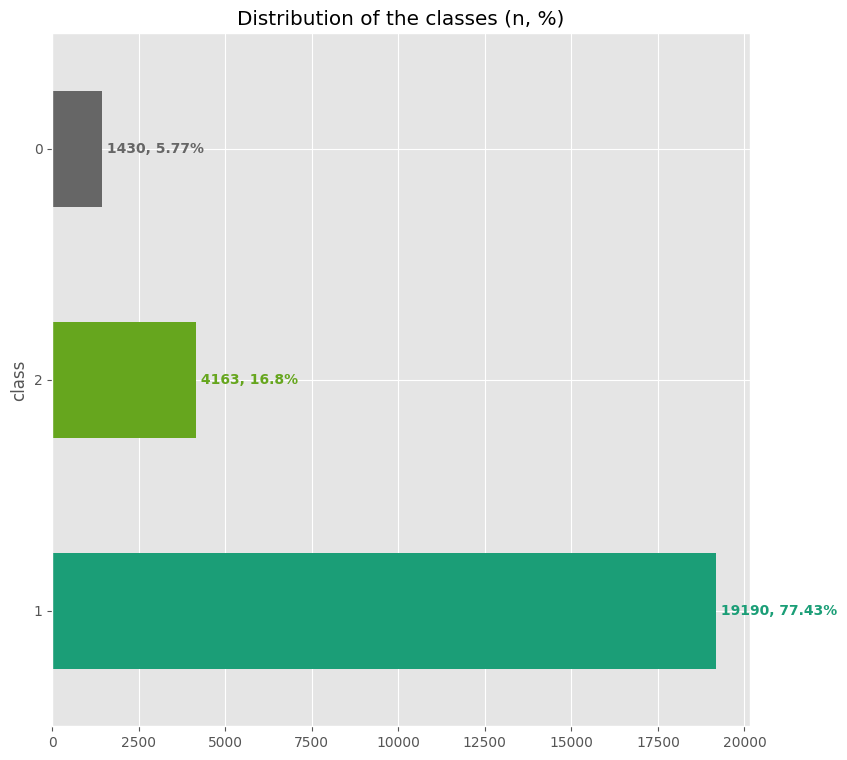

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(dataset["class"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

dataset['class'].value_counts().plot.barh(title="Distribution of the classes (n, %)", 
                                                 ylabel="class",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(dataset['class'].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
            " "+str(v)+", "+str(round(v*100/dataset.shape[0],2))+"%",
            color=c, 
            va='center', 
            fontweight='bold')

In [4]:
dataset.drop(columns=['hate_speech','offensive_language','neither','count'], inplace=True)
#swap the columns tweet and class
datasetm = dataset[['tweet','class']]
datasetm.head()

,tweet,class
0,!!! RT MENTIONHERE: As a woman you shouldn't c...,2
1,!!!!! RT MENTIONHERE: boy dats cold...tyga dwn...,1
2,!!!!!!! RT MENTIONHERE Dawg!!!! RT MENTIONHERE...,1
3,!!!!!!!!! RT MENTIONHERE: MENTIONHERE she look...,1
4,!!!!!!!!!!!!! RT MENTIONHERE: The shit you hea...,1


In [5]:
#add all the texts from data/Reports/neither.txt to the dataset, where the class is neither and the tweet is the text
dataset = datasetm.append(pd.read_csv('../data/Reports/neither.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
#where class = NaN, set it to 2
dataset.loc[dataset['class'].isnull(), 'class'] = 2
dataset.reset_index(drop=True, inplace=True)

C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\3320999717.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = datasetm.append(pd.read_csv('../data/Reports/neither.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\3320999717.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = datasetm.append(pd.read_csv('../data/Reports/neither.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))


In [6]:
#add all the texts from data/Reports/offensive.txt to the dataset, where the class is offensive and the tweet is the text
dataset = dataset.append(pd.read_csv('../data/Reports/offensive.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
#where class = NaN, set it to 1
dataset.loc[dataset['class'].isnull(), 'class'] = 1
dataset.reset_index(drop=True, inplace=True)

C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\3139853063.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = dataset.append(pd.read_csv('../data/Reports/offensive.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\3139853063.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.read_csv('../data/Reports/offensive.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))


In [7]:
#add all the texts from data/Reports/hate_speech.txt to the dataset, where the class is hate_speech and the tweet is the text
dataset = dataset.append(pd.read_csv('../data/Reports/hatespeech.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
#where class = NaN, set it to 0
dataset.loc[dataset['class'].isnull(), 'class'] = 0
dataset.reset_index(drop=True, inplace=True)


C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\2549405253.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = dataset.append(pd.read_csv('../data/Reports/hatespeech.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))
C:\Users\dkras\AppData\Local\Temp\ipykernel_9900\2549405253.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.read_csv('../data/Reports/hatespeech.txt', sep='\r\n', names=['tweet','class'],encoding='iso8859_2', index_col=False))


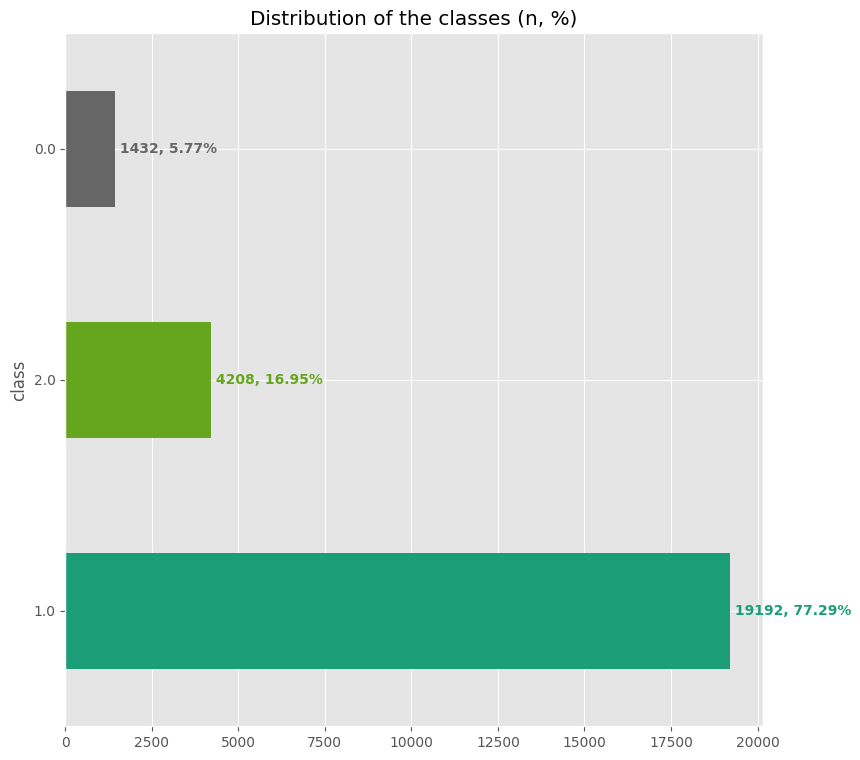

In [8]:
plt.style.use('ggplot')


num_classes = len(dataset["class"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

dataset['class'].value_counts().plot.barh(title="Distribution of the classes (n, %)",
                                                 ylabel="class",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(dataset['class'].value_counts()):
    c = next(iter_color)
    plt.text(v, i,
            " "+str(v)+", "+str(round(v*100/dataset.shape[0],2))+"%",
            color=c,
            va='center',
            fontweight='bold')

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


y = tf.keras.utils.to_categorical(dataset["class"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(dataset['tweet'], y, test_size=0.25)
x_train.head()

8567     Cussed out by a fat redneck on the last day YO...
3323     MENTIONHERE Yeah, so quit being a bitch and edit.
6346     MENTIONHERE aka he wanna keep you warm, should...
12094    Jordan: so Watcha been up to at college Me: fu...
19208    RT MENTIONHERE: #IfWeDate Get rid of Your Ex's...
Name: tweet, dtype: object

In [10]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


In [11]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Hello, what are you doing"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 2.36354843e-01, -1.12736091e-01,  5.76409139e-02,
         1.01531669e-01,  2.54502967e-02, -3.61925185e-01,
        -3.81340146e-01, -7.80289292e-01,  4.86016870e-01,
        -4.22325701e-01, -5.77712774e-01, -7.42388010e-01,
        -1.78767711e-01, -6.89069554e-02, -8.60692978e-01,
        -3.21010172e-01,  8.12912762e-01, -4.75861788e-01,
         2.61291832e-01,  2.41684951e-02, -2.46988505e-01,
         1.05567843e-01, -2.66699731e-01,  5.67520499e-01,
        -1.50627643e-01, -6.95904434e-01, -7.21272975e-02,
         4.72442880e-02, -2.02497765e-01, -7.20782161e-01,
        -2.18936577e-01, -2.89303929e-01, -6.91985488e-01,
        -7.71654785e-01,  2.74948478e-02,  3.59554380e-01,
        -7.66413659e-02, -1.70577109e-01,  3.79003793e-01,
        -1.06028207e-01, -4.01199281e-01,  5.02873361e-02,
        -6.03589833e-01,  5.16455889e-01,  2.02118352e-01,
         3.86882052e-02,  1.04384534e-01, -8.89483914e-02,
      

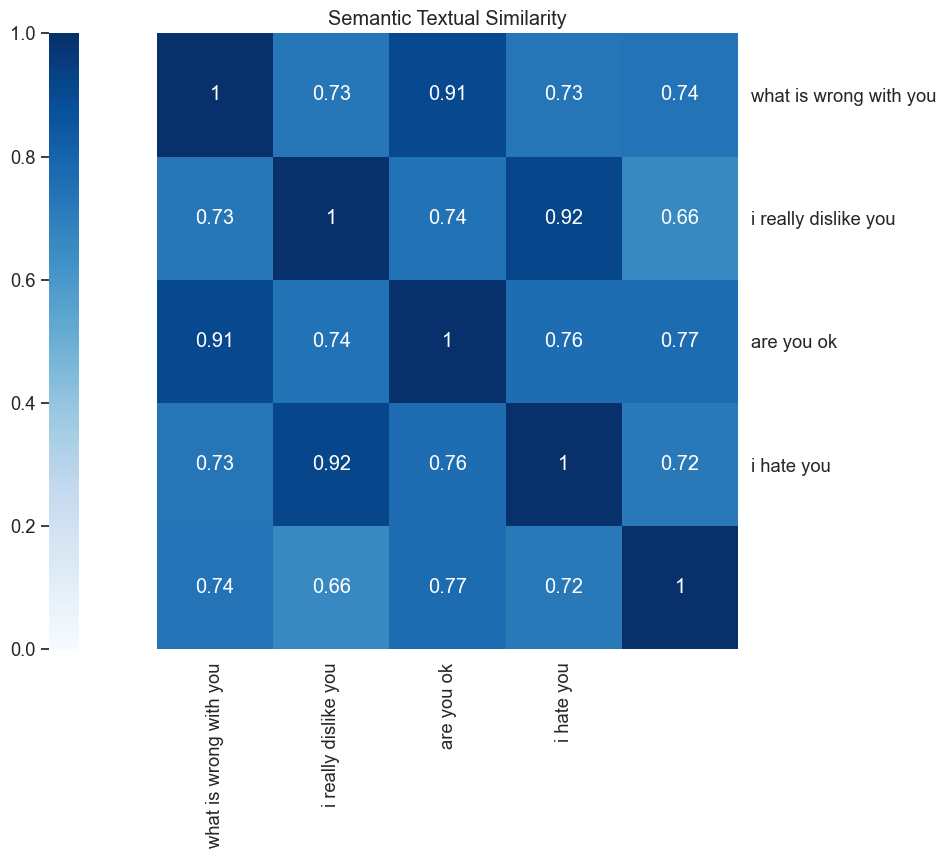

In [12]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = cosine_similarity(features)
  fig = plt.figure(figsize=(10,8))
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, annot=True, cmap="Blues",
      cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

reviews = ["what is wrong with you",
           "i really dislike you",
           "are you ok",
           "i hate you",
           ""
           ]

plot_similarity(get_embeddings(reviews), reviews)

In [13]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [14]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [15]:
n_epochs = 13

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)


model_fit = model.fit(x_train,
                      y_train,
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/13
582/582 [==============================] - 1685s 3s/step - loss: 0.4485 - accuracy: 0.8359 - balanced_recall: 0.4811 - balanced_precision: 0.5358 - balanced_f1_score: 0.5030 - val_loss: 0.3623 - val_accuracy: 0.8645 - val_balanced_recall: 0.5359 - val_balanced_precision: 0.6069 - val_balanced_f1_score: 0.5654

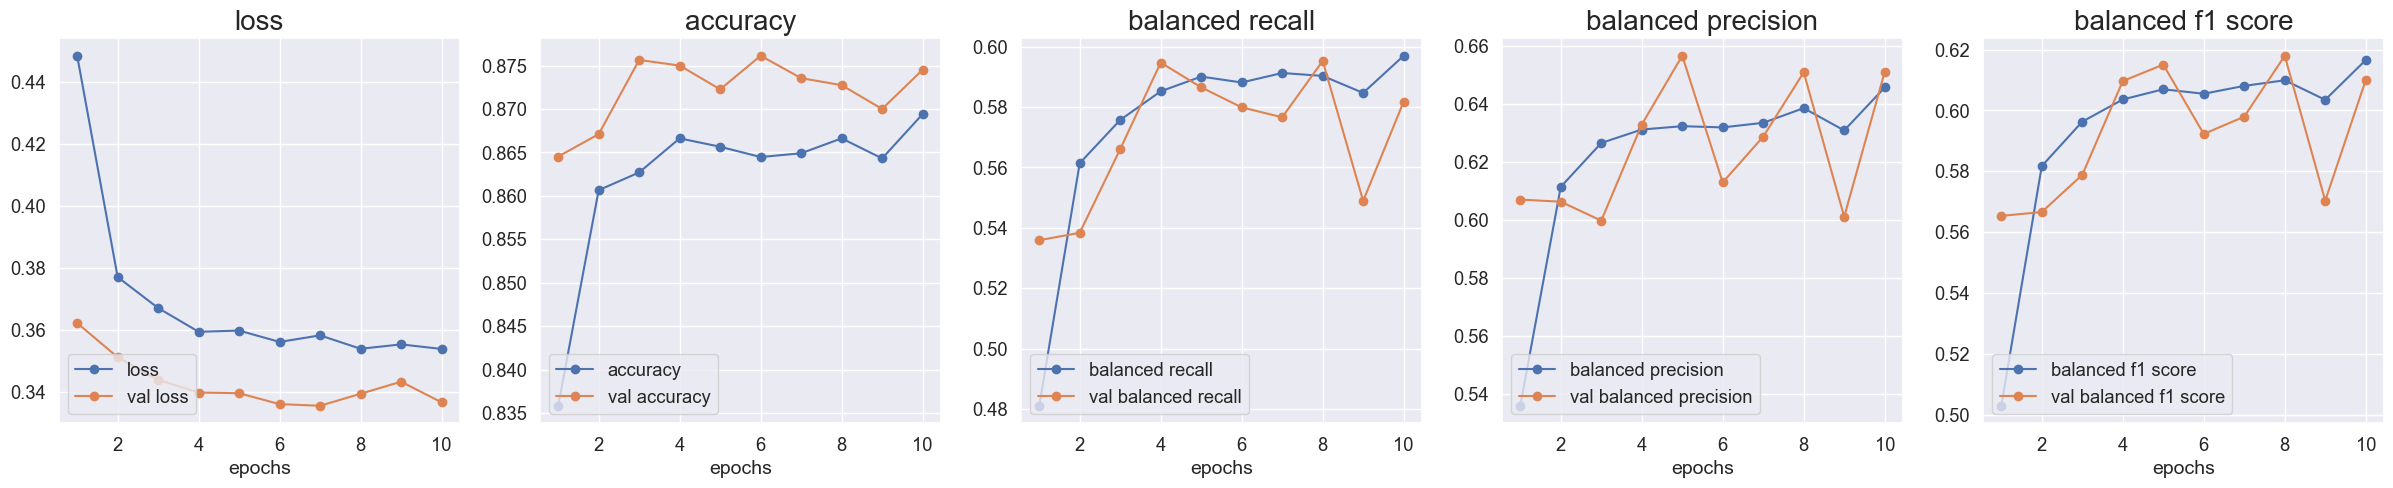

In [17]:
x = list(range(1, 11))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")


In [18]:
reviews = [
    "hello world",
    "what the fuck",
    "Today is a good day"
]

def predict_class(reviews):
    '''predict class of input text
    Args:
    - reviews (list of strings)
    Output:
     - class (list of int)
    '''

    print("----")
    return [np.argmax(pred) for pred in model.predict(reviews)]


predict_class(reviews)


----
1/1 [==============================] - 2s 2s/step


[2, 1, 2]

In [19]:
model.save("models/text_classifier_v3")


INFO:tensorflow:Assets written to: models/text_classifier_v3\assets


INFO:tensorflow:Assets written to: models/text_classifier_v3\assets


In [ ]:
from tensorflow import keras

# load model
new_model = keras.models.load_model("models/text_classifier_v3",custom_objects={'balanced_recall': balanced_recall,
                                                                                 'balanced_precision': balanced_precision,
                                                                                 'balanced_f1_score': balanced_f1_score})

[np.argmax(pred) for pred in new_model.predict(reviews)]